In [45]:
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [13]:
def svd_least_square(a_matrix):
    _, _, vt = np.linalg.svd(a_matrix)
    x = vt[-1].reshape((3, 3))
    return x

In [14]:
def relation_matrix(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.array(
        [[x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2],
         [0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2]]
    )

In [15]:
pts1 = [[100, 200], [100, 1400], [1000, 200], [1000, 1400]]
pts2 = [[311, 450], [12, 891], [812, 436], [1000, 895]]

In [16]:
A = np.vstack([relation_matrix(p, q) for p, q in zip(pts1, pts2)])

In [17]:
H = svd_least_square(A)
H

array([[ 9.58820911e-04, -4.63844160e-04,  5.64756498e-01],
       [-5.93442482e-05,  1.17819790e-05,  8.25254527e-01],
       [-7.09647159e-08, -7.39903286e-07,  1.98102490e-03]])

In [18]:
source = cv2.imread('Delta-Building.jpg')
target = np.zeros_like(source)

In [23]:
warp_pt = H @ np.array([100, 200, 1])
warp_pt / warp_pt[2]

array([311., 450.,   1.])

In [28]:
indices = np.array(list(itertools.product(range(target.shape[0]), range(target.shape[1]), [1])))

In [53]:
def bilinear_pixel_color(src, x, y):
    if x < 0 or x >= src.shape[0] - 1 or y < 0 or y >= src.shape[1] - 1:
        return np.array([0, 0, 0])

    px, py = int(x), int(y)
    a = src[px, py]
    b = src[px, py + 1]
    c = src[px + 1, py]
    d = src[px + 1, py + 1]
    dx, dy = x % 1, y % 1

    return (a * dy + b * (1 - dy)) * dx + (c * dy + d * (1 - dy)) * (1 - dx)

In [ ]:
# [TODO] migrate to py

In [53]:
def bilinear_pixel_color(src, px, py, dx, dy):
    if px < 0 or px >= src.shape[0] - 1 or py < 0 or py >= src.shape[1] - 1:
        return np.array([0, 0, 0])

    # px, py = int(x), int(y)
    a = src[px, py]
    b = src[px, py + 1]
    c = src[px + 1, py]
    d = src[px + 1, py + 1]
    # dx, dy = x % 1, y % 1

    return (a * dy + b * (1 - dy)) * dx + (c * dy + d * (1 - dy)) * (1 - dx)

In [54]:
W = (H @ indices[..., np.newaxis]).reshape((-1, 3))
W = (W / W[:, 2:])
W.shape

(1708800, 3)

In [55]:
Wp = W.astype(int)
dW = W % 1

In [56]:
for m in tqdm.tqdm(range(W.shape[0])):
    warp_pt = Wp[m]
    warp_dpt = dW[m]
    i, j = divmod(m, target.shape[1])
    target[i, j] = bilinear_pixel_color(source, warp_pt[0], warp_pt[1],
                                        warp_dpt[0], warp_dpt[1])

target

100%|██████████| 1708800/1708800 [00:24<00:00, 70444.48it/s]


array([[[207, 211, 192],
        [207, 211, 192],
        [207, 211, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[207, 211, 192],
        [207, 211, 192],
        [207, 211, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[207, 211, 192],
        [207, 211, 192],
        [207, 211, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 57, 126, 114],
        [ 35, 117, 101],
        [ 38, 118, 103],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 72, 131, 121],
        [ 52, 124, 108],
        [ 55, 125, 110],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 33, 123, 108],
        [ 18, 120, 102],
        [ 20, 119, 101],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

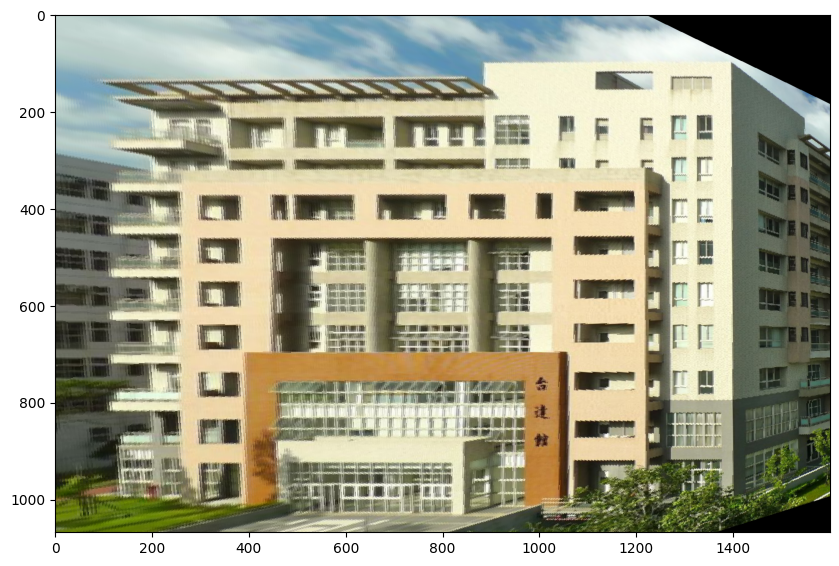

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(target[..., ::-1])